<a href="https://colab.research.google.com/github/Shyhoon-Moontaka/cnn-image-classification/blob/main/210105.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Shyhoon-Moontaka/cnn-image-classification.git
%cd cnn-image-classification

Cloning into 'cnn-image-classification'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 43 (delta 0), reused 16 (delta 0), pack-reused 27 (from 1)
Receiving objects: 100% (43/43), 28.48 MiB | 20.30 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/cnn-image-classification


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


In [4]:
classes = ["Circle", "Square", "Triangle"]
num_classes = len(classes)

In [5]:
train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(32),
    transforms.CenterCrop(28),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

phone_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(32),
    transforms.CenterCrop(28),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [6]:
train_data = ImageFolder(root="dataset", transform=train_transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)

In [7]:
from torch.utils.data import random_split

train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [8]:
class CNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [9]:
model = CNN(num_classes=num_classes).to(device)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [24]:
epochs = 10
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(epochs):
    model.train()
    correct, total, loss_sum = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_losses.append(loss_sum / len(train_loader))
    train_accs.append(correct / total)

    # Validation
    model.eval()
    correct_val, total_val, val_loss_sum = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_sum += loss.item()
            correct_val += (outputs.argmax(1) == labels).sum().item()
            total_val += labels.size(0)
    val_losses.append(val_loss_sum / len(val_loader))
    val_accs.append(correct_val / total_val)

    print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]:.4f}, Acc: {train_accs[-1]*100:.2f}% | Val Loss: {val_losses[-1]:.4f}, Acc: {val_accs[-1]*100:.2f}%")

Epoch 1 | Train Loss: 0.9225, Acc: 87.50% | Val Loss: 1.5771, Acc: 0.00%
Epoch 2 | Train Loss: 0.8923, Acc: 75.00% | Val Loss: 1.6595, Acc: 0.00%
Epoch 3 | Train Loss: 0.8588, Acc: 87.50% | Val Loss: 1.6663, Acc: 0.00%
Epoch 4 | Train Loss: 0.8213, Acc: 87.50% | Val Loss: 1.6527, Acc: 0.00%
Epoch 5 | Train Loss: 0.7822, Acc: 87.50% | Val Loss: 1.6890, Acc: 0.00%
Epoch 6 | Train Loss: 0.7404, Acc: 75.00% | Val Loss: 1.7984, Acc: 0.00%
Epoch 7 | Train Loss: 0.6976, Acc: 75.00% | Val Loss: 1.9229, Acc: 0.00%
Epoch 8 | Train Loss: 0.6519, Acc: 75.00% | Val Loss: 1.9921, Acc: 0.00%
Epoch 9 | Train Loss: 0.6071, Acc: 87.50% | Val Loss: 2.0310, Acc: 0.00%
Epoch 10 | Train Loss: 0.5588, Acc: 87.50% | Val Loss: 2.0416, Acc: 0.00%


In [25]:
torch.save(model.state_dict(), "210105.pth")
print("✅ Model saved!")

✅ Model saved!


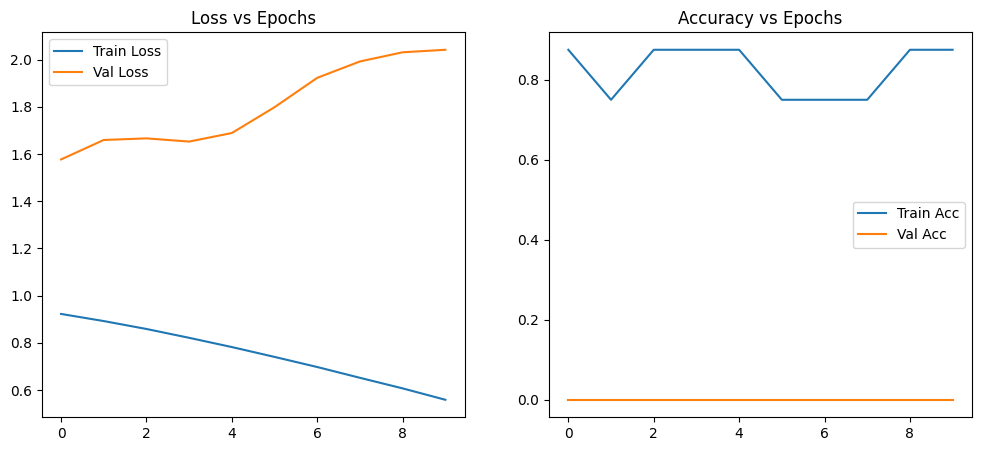

In [26]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss vs Epochs")

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend()
plt.title("Accuracy vs Epochs")
plt.show()

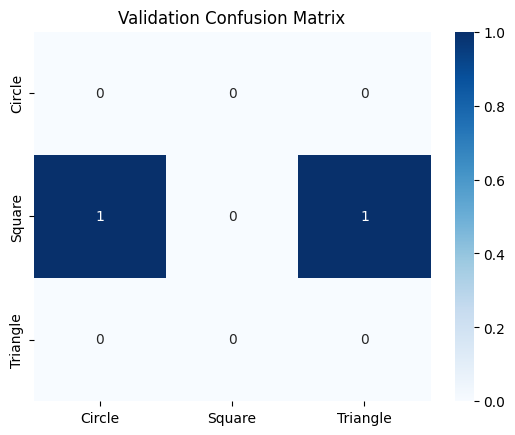

In [27]:
y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(1).cpu()
        y_true.extend(labels.numpy())
        y_pred.extend(preds.numpy())

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Validation Confusion Matrix")
plt.show()

In [28]:
def predict_phone_image(path):
    img = Image.open(path)
    img_t = phone_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(img_t)
        prob = torch.softmax(out, dim=1)
        cls = prob.argmax(1).item()
        conf = prob.max().item() * 100
    return classes[cls], conf

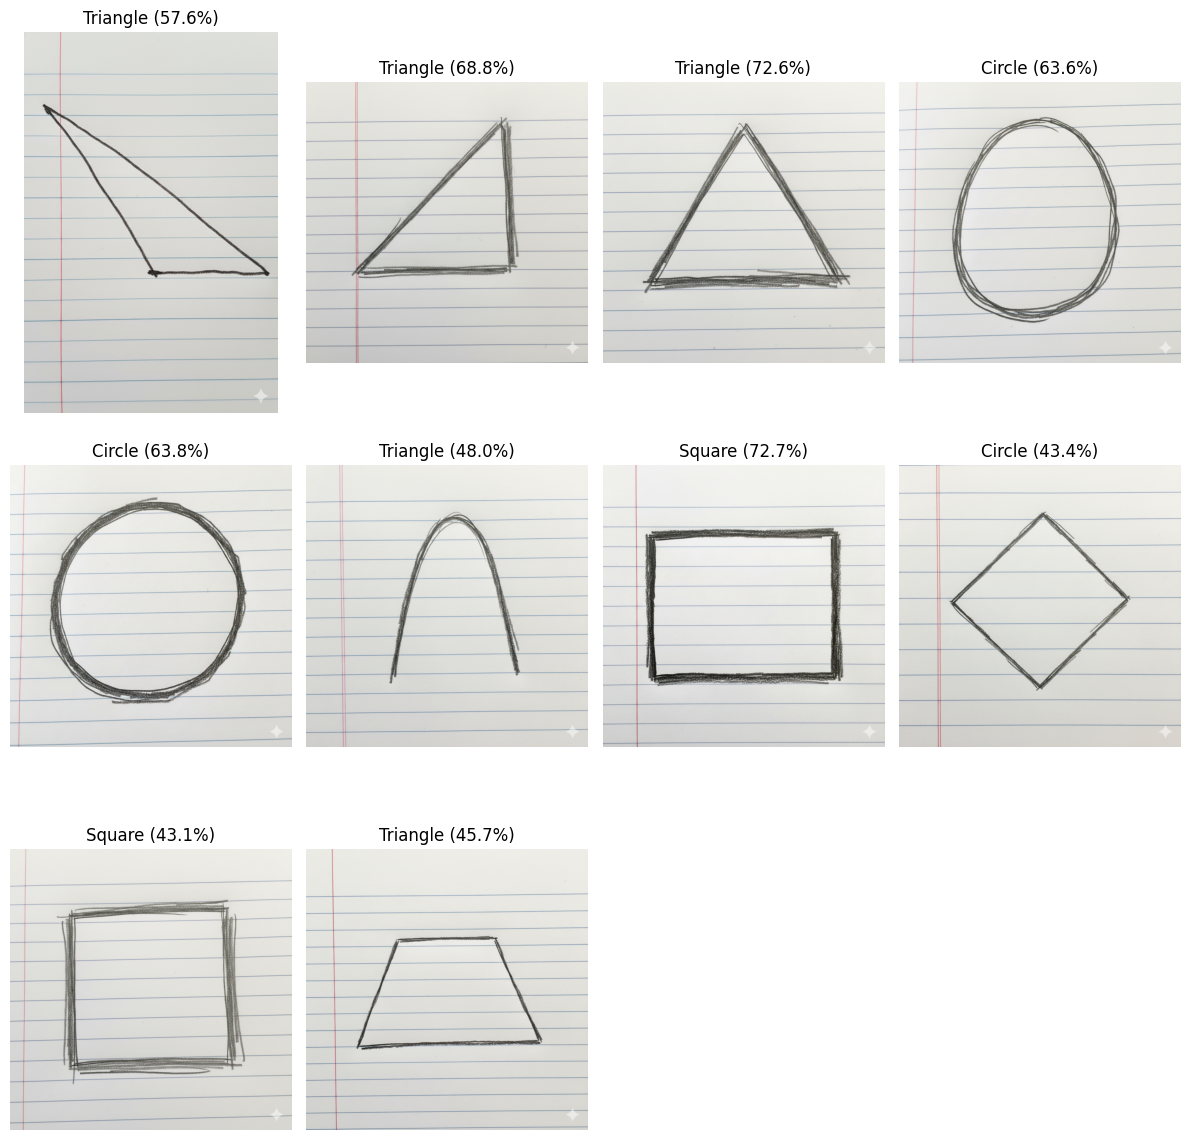

In [29]:
img_dir = "dataset"
plt.figure(figsize=(12, 12))
i = 1

for folder_name in os.listdir(img_dir):
    folder_path = os.path.join(img_dir, folder_name)
    if os.path.isdir(folder_path):
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            pred, conf = predict_phone_image(img_path)
            img = Image.open(img_path)

            plt.subplot(3, 4, i)
            plt.imshow(img)
            plt.title(f"{pred} ({conf:.1f}%)")
            plt.axis("off")
            i += 1

plt.tight_layout()
plt.show()

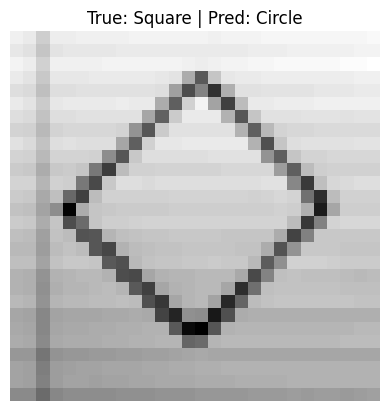

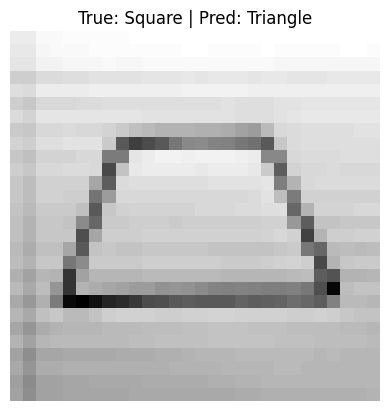

In [30]:
errors = [(i, y_true[i], y_pred[i]) for i in range(len(y_true)) if y_true[i] != y_pred[i]]
if len(errors) > 0:
    samples = np.random.choice(len(errors), min(3,len(errors)), replace=False)
    for idx in samples:
        i, t, p = errors[idx]
        img, _ = val_dataset[i]
        plt.imshow(img.squeeze(), cmap="gray")
        plt.title(f"True: {classes[t]} | Pred: {classes[p]}")
        plt.axis("off")
        plt.show()